#### **Análisis Exploratorio de Datos (EDA)**

Crearé gráficos para visualizar los datos de manera efectiva. Estas visualizaciones serán fundamentales para identificar patrones, relaciones y posibles outliers en las variables de mis datasets. Con base en estos análisis, tomaré decisiones informadas sobre el modelo de machine learning más adecuado para desarrollar mi sistema de recomendación. Me enfocaré en gráficos como histogramas, scatter plots y nubes de palabras para explorar las características más relevantes.

#### **Importo las Librerías Necesarias**

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import pyarrow.parquet as pq   

#### **Cargo los archivos Parquet**

In [2]:
# Definir las rutas de los archivos
ruta_movies = 'Datasets/movies_df.parquet'
ruta_credits = 'Datasets/credits_df.parquet'
ruta_crew = 'Datasets/crew_df.parquet'
ruta_cast = 'Datasets/cast_df.parquet'

# Cargar los archivos Parquet en DataFrames
movies_df = pd.read_parquet(ruta_movies)
credits_df = pd.read_parquet(ruta_credits)
crew_df = pd.read_parquet(ruta_crew)
cast_df = pd.read_parquet(ruta_cast)

#### **Visualización de la relación entre presupuesto e ingresos**

Voy a crear un gráfico de dispersión para analizar la relación entre el presupuesto de una película y sus ingresos. Esta visualización es fundamental para mi proyecto de sistema de recomendación, ya que entender cómo se relacionan estas variables puede mejorar la precisión del modelo.

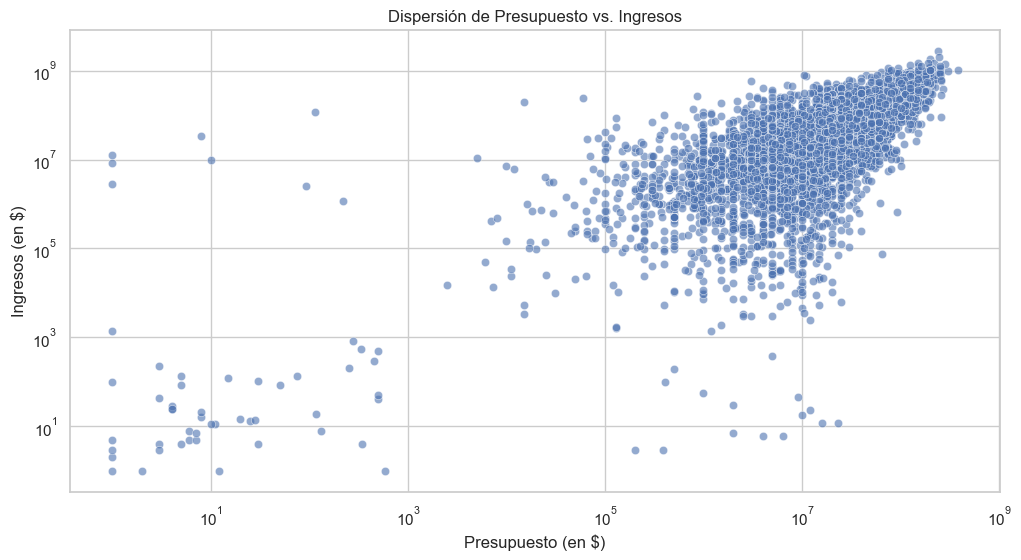

In [3]:
# Configuración de estilo para gráficos
sns.set(style="whitegrid")

# Gráfico de dispersión: Presupuesto vs. Ingresos
plt.figure(figsize=(12, 6))
sns.scatterplot(data=movies_df, x='budget', y='revenue', alpha=0.6)
plt.title('Dispersión de Presupuesto vs. Ingresos')
plt.xlabel('Presupuesto (en $)')
plt.ylabel('Ingresos (en $)')
plt.xscale('log')  # Escala logarítmica para mejor visualización
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.grid(True)
plt.show()

**Dispersion de Presupuesto vs. Ingresos:** 

En el gráfico, observo una tendencia positiva: a mayor presupuesto, los ingresos tienden a ser más altos. Sin embargo, hay outliers, como películas con presupuestos bajos que generaron ingresos elevados y otras con presupuestos altos que no alcanzaron los esperados. Estos casos son importantes, ya que pueden ofrecer insights valiosos para el desarrollo de mi modelo de recomendación.

#### **Distribución de los puntajes promedio**

Voy a examinar la distribución de los puntajes promedio de las películas utilizando un histograma. Esta visualización me ayudará a entender cómo se distribuyen las calificaciones en el dataset, lo cual es relevante para mi modelo de recomendación. Identificar películas con altos puntajes puede ayudar a priorizarlas en las recomendaciones.

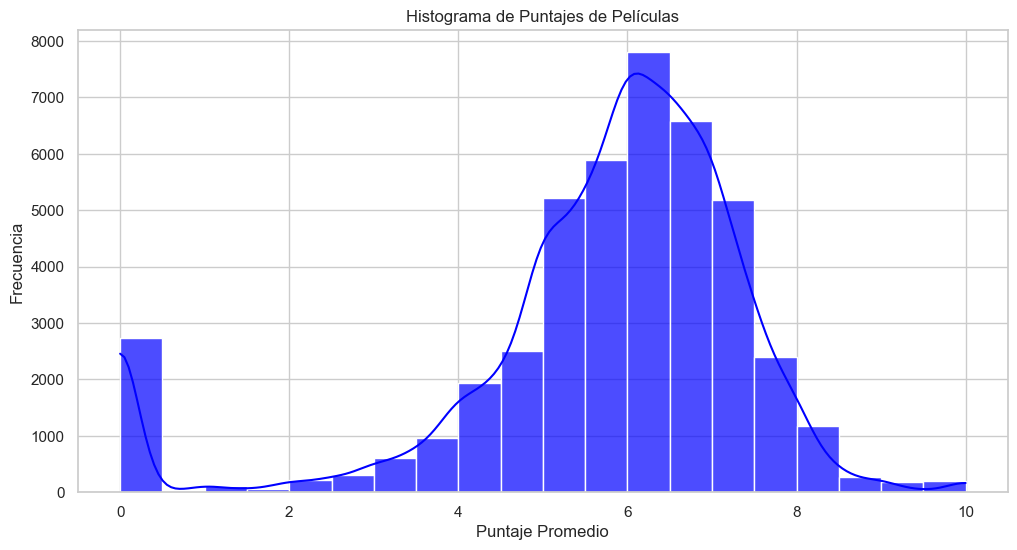

In [4]:
# Histograma de puntajes
plt.figure(figsize=(12, 6))
sns.histplot(movies_df['vote_average'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histograma de Puntajes de Películas')
plt.xlabel('Puntaje Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

**Histograma de Puntajes Promedio:** 

La distribución de puntajes promedio presenta una forma aproximadamente normal con una ligera asimetría a la izquierda. La mayoría de las películas se agrupan entre puntajes de 5 a 7, indicando una tendencia hacia calificaciones medias. Sin embargo, hay outliers en el rango bajo (puntajes cercanos a 0), que podrían representar películas con malas críticas o errores en los datos. Dado que estos puntajes pueden reflejar opiniones reales, no considero necesario eliminarlos, pero los tendré en cuenta en el análisis de recomendaciones para asegurar que no afecten desproporcionadamente al sistema.

#### **Análisis de Outliers:**

Profundizaré en el análisis de outliers que encontre en la distribución de puntajes y en la relación entre presupuesto e ingresos. Investigaré por qué algunas películas tienen calificaciones extremadamente bajas o altas y cómo esto puede afectar miss recomendaciones.

In [5]:
def identificar_outliers(df, columna):
    # Calcular Q1 y Q3
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    
    return outliers

# Identificar outliers en 'popularity' y 'runtime'
outliers_popularity = identificar_outliers(movies_df, 'popularity')
outliers_runtime = identificar_outliers(movies_df, 'runtime')

# Mostrar los outliers
print("Outliers en 'popularity':")
print(outliers_popularity)

print("\nOutliers en 'runtime':")
print(outliers_runtime)


Outliers en 'popularity':
         budget      id original_language  \
0      30000000     862                en   
1      65000000    8844                en   
2             0   15602                en   
5      60000000     949                en   
9      58000000     710                en   
...         ...     ...               ...   
44131         0  451955                fr   
44149         0  417320                en   
44252         0   79927                en   
44257         0  426272                en   
44317         0  455661                en   

                                                overview  popularity  \
0      Led by Woody, Andy's toys live happily in his ...   21.946943   
1      When siblings Judy and Peter discover an encha...   17.015539   
2      A family wedding reignites the ancient feud be...   11.712900   
5      Obsessive master thief, Neil McCauley leads a ...   17.924927   
9      James Bond must unmask the mysterious head of ...   14.686036   
.

He calculado los cuartiles Q1 y Q3 para identificar los outliers en las columnas 'popularity' y 'runtime' utilizando el método del rango intercuartílico (IQR). Dado que el número de datos identificados como outliers no es muy alto en comparación con el tamaño total del dataset, considero más conveniente eliminarlos para evitar que afecten el análisis posterior. A continuación, procederé a eliminar estos registros del DataFrame.

In [6]:
# Calcular el IQR para 'popularity' y 'runtime'
Q1_popularity = movies_df['popularity'].quantile(0.25)
Q3_popularity = movies_df['popularity'].quantile(0.75)
IQR_popularity = Q3_popularity - Q1_popularity

Q1_runtime = movies_df['runtime'].quantile(0.25)
Q3_runtime = movies_df['runtime'].quantile(0.75)
IQR_runtime = Q3_runtime - Q1_runtime

# Definir los límites para detectar outliers
lower_bound_popularity = Q1_popularity - 1.5 * IQR_popularity
upper_bound_popularity = Q3_popularity + 1.5 * IQR_popularity

lower_bound_runtime = Q1_runtime - 1.5 * IQR_runtime
upper_bound_runtime = Q3_runtime + 1.5 * IQR_runtime

# Eliminar outliers
movies_cleaned = movies_df[
    (movies_df['popularity'] >= lower_bound_popularity) & (movies_df['popularity'] <= upper_bound_popularity) &
    (movies_df['runtime'] >= lower_bound_runtime) & (movies_df['runtime'] <= upper_bound_runtime)
]

# Mostrar el tamaño del DataFrame después de la limpieza
print(f"Tamaño del DataFrame original: {movies_df.shape[0]}")
print(f"Tamaño del DataFrame limpio: {movies_cleaned.shape[0]}")



Tamaño del DataFrame original: 44344
Tamaño del DataFrame limpio: 35771


La limpieza del DataFrame, que redujo su tamaño de 44,344 a 35,771 registros al eliminar 8,573 outliers en las variables 'popularity' y 'runtime', es un paso crucial para el desarrollo de un modelo más robusto y preciso. Esta reducción en el tamaño no solo mejora la calidad del conjunto de datos, sino que también permite un análisis más claro de las relaciones entre 'popularity', 'runtime', 'revenue', 'budget', 'vote_average', 'release_year' y 'genres'. Así, se facilita el entrenamiento del modelo al reducir la variabilidad no deseada, lo que puede resultar en un mejor rendimiento predictivo.

#### **Integrar los DataFrames**

Uniré los datasets para integrar toda la información relevante de las películas, incluyendo datos financieros, popularidad, y detalles del elenco y equipo técnico. Esto me permitirá realizar un análisis más completo y desarrollar modelos predictivos más precisos.

In [7]:
# Unir el DataFrame de crew al de películas
movies_with_crew = pd.merge(movies_df, crew_df, on='id', how='left')

# Unir el DataFrame de cast al de películas
movies_with_full_info = pd.merge(movies_with_crew, cast_df, on='id', how='left')

# Verificamos el tamaño y las primeras filas del nuevo DataFrame
print(movies_with_full_info.shape)
print(movies_with_full_info.head())


(8771575, 25)
     budget   id original_language  \
0  30000000  862                en   
1  30000000  862                en   
2  30000000  862                en   
3  30000000  862                en   
4  30000000  862                en   

                                            overview  popularity release_date  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
1  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
2  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
3  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
4  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   

       revenue  runtime    status      title  ...  language_names  \
0  373554033.0     81.0  Released  Toy Story  ...         English   
1  373554033.0     81.0  Released  Toy Story  ...         English   
2  373554033.0     81.0  Released  Toy Story  ...         Engli

In [8]:
# Unir el DataFrame de crew con el de cast
crew_cast_df = pd.merge(crew_df, cast_df, on='id', how='left')

# Verificamos el tamaño y las primeras filas del nuevo DataFrame
print(crew_cast_df.shape)
print(crew_cast_df.head())


(8794607, 8)
    id      crew_name  crew_job department  gender_x      cast_name  \
0  862  John Lasseter  Director  Directing         2      Tom Hanks   
1  862  John Lasseter  Director  Directing         2      Tim Allen   
2  862  John Lasseter  Director  Directing         2    Don Rickles   
3  862  John Lasseter  Director  Directing         2     Jim Varney   
4  862  John Lasseter  Director  Directing         2  Wallace Shawn   

                 character  gender_y  
0            Woody (voice)       2.0  
1   Buzz Lightyear (voice)       2.0  
2  Mr. Potato Head (voice)       2.0  
3       Slinky Dog (voice)       2.0  
4              Rex (voice)       2.0  


In [9]:
# Unir el DataFrame de películas con crew_cast_df
movies_complete_df = pd.merge(movies_df, crew_cast_df, on='id', how='left')

# Verificamos el tamaño y las primeras filas del nuevo DataFrame
print(movies_complete_df.shape)
print(movies_complete_df.head())


(8770614, 25)
     budget   id original_language  \
0  30000000  862                en   
1  30000000  862                en   
2  30000000  862                en   
3  30000000  862                en   
4  30000000  862                en   

                                            overview  popularity release_date  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
1  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
2  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
3  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
4  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   

       revenue  runtime    status      title  ...  language_names  \
0  373554033.0     81.0  Released  Toy Story  ...         English   
1  373554033.0     81.0  Released  Toy Story  ...         English   
2  373554033.0     81.0  Released  Toy Story  ...         Engli

He unido los DataFrames `movies_df`, `crew_df` y `cast_df`, creando un nuevo DataFrame llamado `movies_complete_df`, que contiene información completa sobre las películas, el equipo de producción y el reparto. Este nuevo DataFrame tiene un total de **8,770,614 filas** y **25 columnas**.

Voy a limpiar mis datos eliminando duplicados y verificando si hay valores nulos. También me aseguraré de que las columnas tengan el tipo de dato correcto y guardaré el DataFrame limpio como un nuevo archivo Parquet. Esto me ayudará a trabajar con un conjunto de datos más confiable y manejable.

In [10]:
# Eliminar duplicados
movies_complete_df = movies_complete_df.drop_duplicates()
print(f"* Número de filas después de eliminar duplicados: {movies_complete_df.shape[0]}")


* Número de filas después de eliminar duplicados: 8761748


In [11]:
# Verificar valores nulos
nulos = movies_complete_df.isnull().sum()
print(f"* Resumen de valores nulos: {nulos}")

* Resumen de valores nulos: budget                          0
id                              0
original_language               0
overview                        0
popularity                      0
release_date                    0
revenue                         0
runtime                         0
status                          0
title                           0
vote_average                    0
vote_count                      0
production_company_names        0
genre_names                     0
country_names                   0
language_names                  0
release_year                    0
return                          0
crew_name                     647
crew_job                      647
department                    647
gender_x                      647
cast_name                   11436
character                   11436
gender_y                    11436
dtype: int64


In [12]:
# Crear un nuevo DataFrame a partir del existente
movies_cleaned_df = movies_complete_df.copy()

# Ahora puedes trabajar con 'movies_cleaned_df' sin afectar 'movies_complete_df'


In [13]:
# Eliminar filas con valores nulos en las columnas críticas
movies_cleaned_df.dropna(subset=['crew_name', 'crew_job', 'department', 'cast_name', 'character'], inplace=True)

# Verificar el tamaño del nuevo DataFrame
print(f"Número de filas después de eliminar nulos: {movies_cleaned_df.shape[0]}")

# Guardar el nuevo DataFrame limpio en un archivo Parquet
movies_cleaned_df.to_parquet('Datasets/movies_cleaned.parquet', index=False)
print("Datos limpiados y guardados como 'Datasets/movies_cleaned.parquet'")


Número de filas después de eliminar nulos: 8750312
Datos limpiados y guardados como 'Datasets/movies_cleaned.parquet'


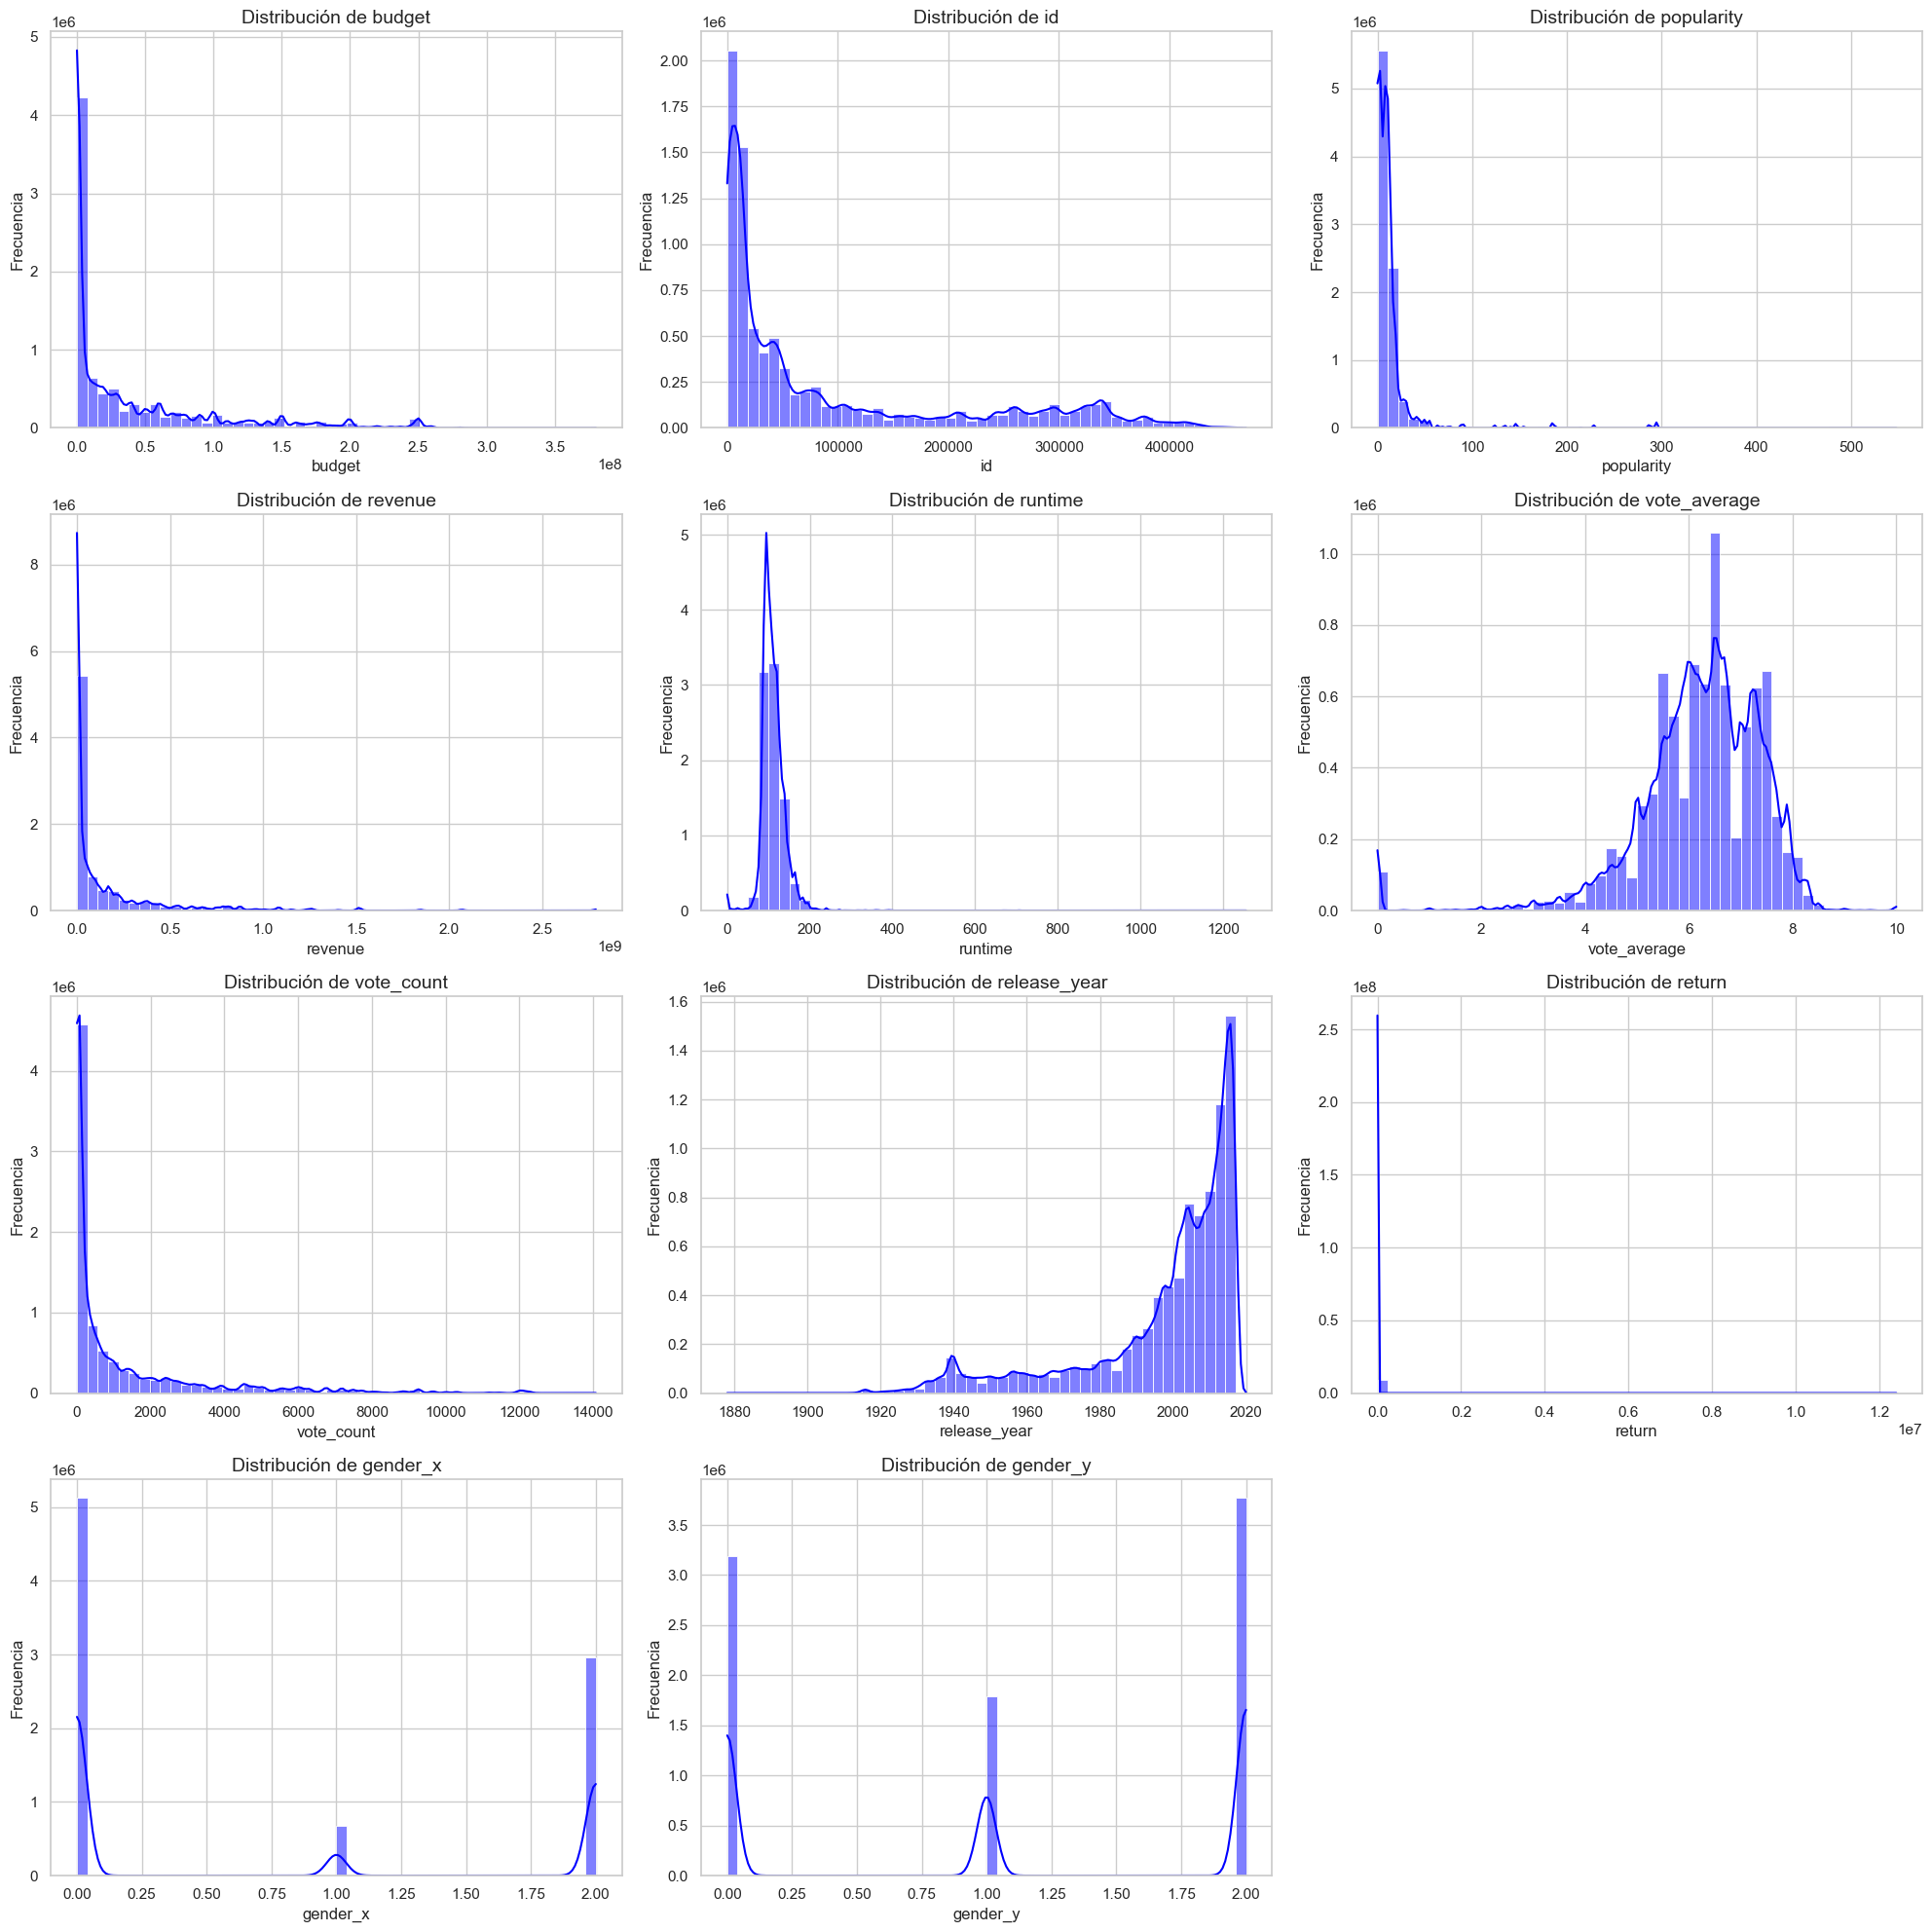

In [14]:
# Configurar el estilo de los gráficos
sns.set(style='whitegrid')

# Crear un gráfico para cada columna numérica
numeric_columns = movies_cleaned_df.select_dtypes(include=['float64', 'int64']).columns

# Definir el número de filas y columnas para subgráficos
num_cols = 3  # Número de columnas en el gráfico
num_rows = (len(numeric_columns) // num_cols) + (len(numeric_columns) % num_cols > 0)  # Número de filas

# Crear la figura con subgráficos
plt.figure(figsize=(20, num_rows * 5))

for i, column in enumerate(numeric_columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Subgráficos
    sns.histplot(movies_cleaned_df[column], bins=50, kde=True, color='blue')  # Histograma
    plt.title(f'Distribución de {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.show()  # Mostrar todos los gráficos


Aquí puedo ver claramente las distribuciones de mis variables clave. Por ejemplo, budget y revenue están muy sesgadas hacia la izquierda, lo que indica la presencia de muchos valores bajos en comparación con algunos casos extremos. La variable runtime tiene una distribución más normal, aunque con algunos valores atípicos. Noté también que las variables de gender parecen estar categorizadas de manera muy definida, lo que podría ser importante para análisis futuros. Esto me da pistas sobre qué variables podrían necesitar transformaciones adicionales o un tratamiento específico para modelar correctamente.

#### **Barplot de Actores con Más Participaciones**

C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_12908\3517078184.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='actor', data=actors_count.head(10), palette='viridis')


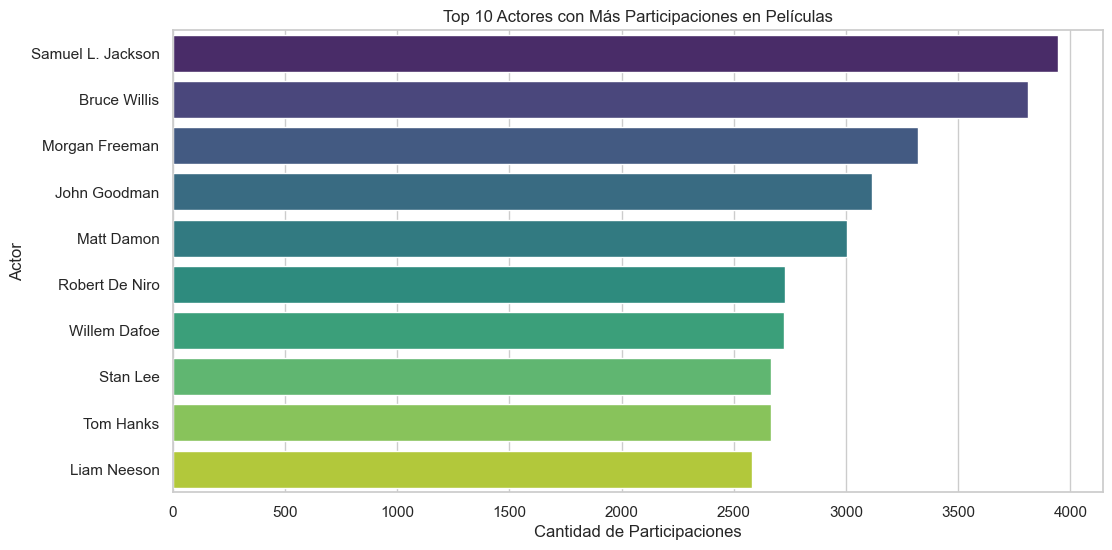

C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_12908\3517078184.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='director', data=directors_count.head(10), palette='viridis')


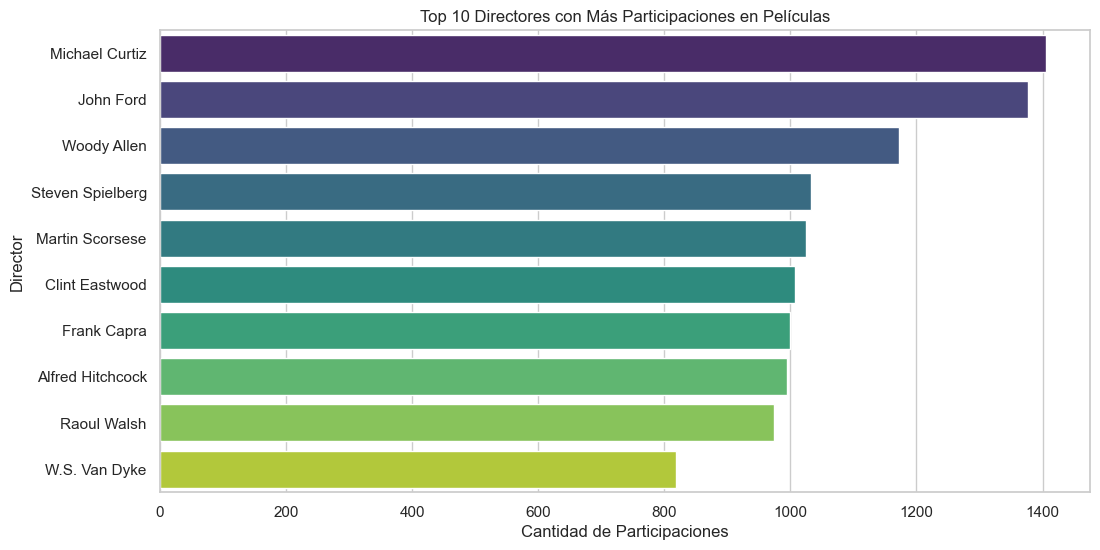

In [15]:
# 1. Contar las participaciones de actores
actors_count = movies_cleaned_df['cast_name'].value_counts().reset_index()
actors_count.columns = ['actor', 'count']

# Gráfico de los 10 actores con más participaciones
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='actor', data=actors_count.head(10), palette='viridis')
plt.title('Top 10 Actores con Más Participaciones en Películas')
plt.xlabel('Cantidad de Participaciones')
plt.ylabel('Actor')
plt.show()

# 2. Contar las participaciones de directores
directors_count = movies_cleaned_df[movies_cleaned_df['crew_job'] == 'Director']['crew_name'].value_counts().reset_index()
directors_count.columns = ['director', 'count']

# Gráfico de los 10 directores con más participaciones
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='director', data=directors_count.head(10), palette='viridis')
plt.title('Top 10 Directores con Más Participaciones en Películas')
plt.xlabel('Cantidad de Participaciones')
plt.ylabel('Director')
plt.show()


C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_12908\3041122353.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='count', data=movies_per_year, palette='viridis')


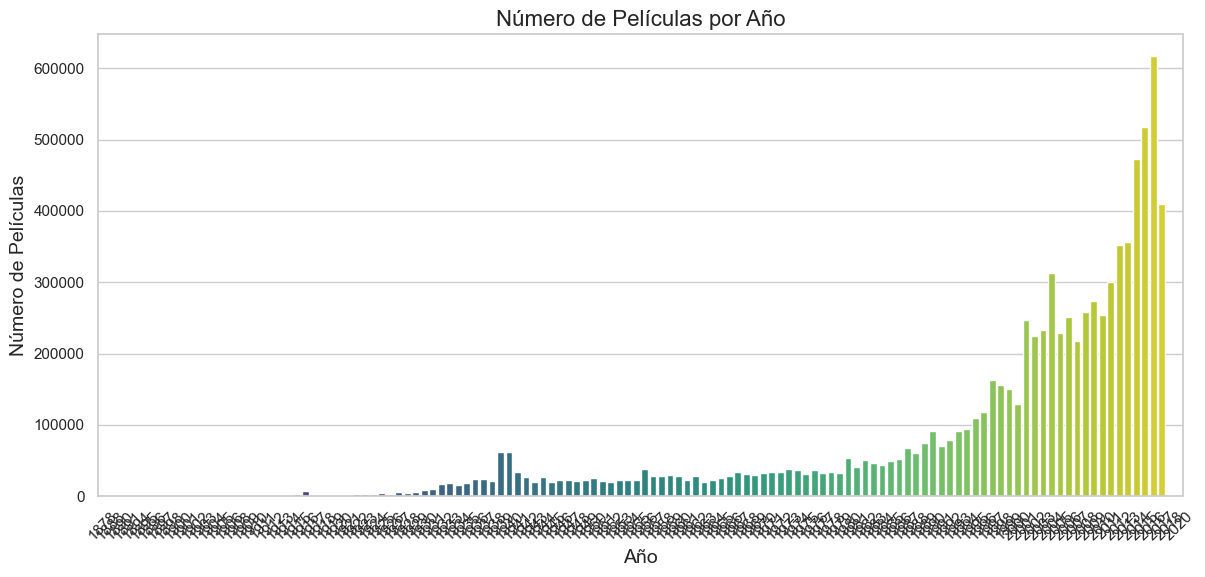

In [16]:
# Asegúrate de que release_year sea de tipo entero
movies_cleaned_df['release_year'] = movies_cleaned_df['release_year'].astype(int)

# Contar el número de películas por año
movies_per_year = movies_cleaned_df['release_year'].value_counts().reset_index()
movies_per_year.columns = ['year', 'count']
movies_per_year = movies_per_year.sort_values('year')  # Ordenar por año

# Gráfico
plt.figure(figsize=(14, 6))
sns.barplot(x='year', y='count', data=movies_per_year, palette='viridis')
plt.title('Número de Películas por Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Películas', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()


#### **Filtrar Películas Desde 1970**

Eliminar las películas que se lanzaron antes de 1970 en tu DataFrame movies_cleaned_df,

In [17]:
# Filtrar películas desde el año 1970
movies_cleaned_df = movies_cleaned_df[movies_cleaned_df['release_year'] >= 1970]

# Verificar cuántas películas quedan
print(f"Número de películas desde 1970: {len(movies_cleaned_df)}")


Número de películas desde 1970: 7669027


C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_12908\835270681.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='count', data=movies_per_year, palette='viridis')


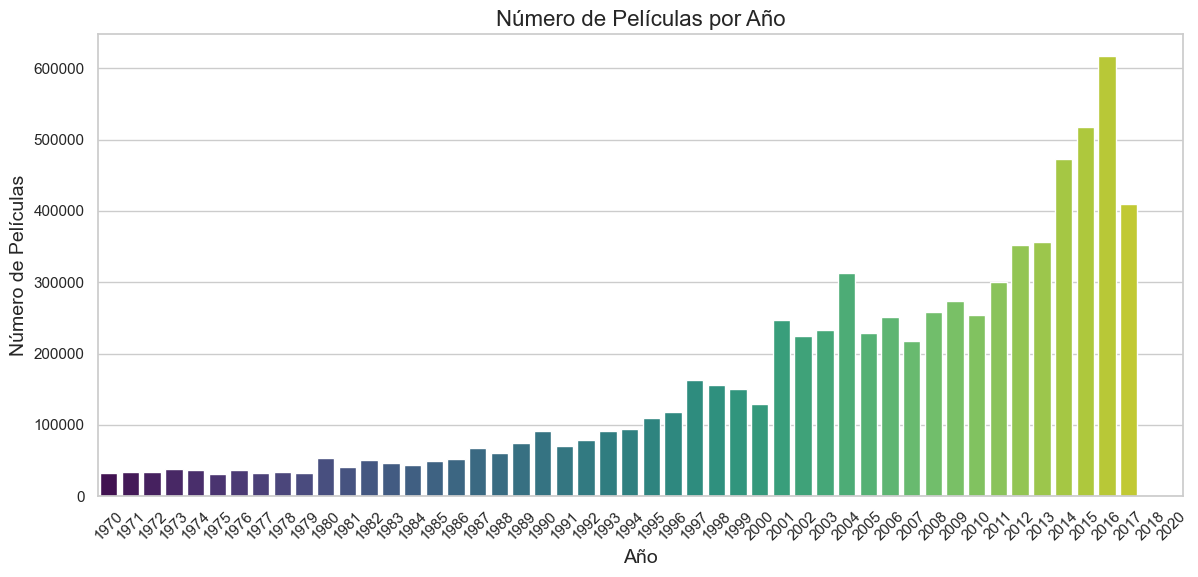

In [18]:
# Asegúrate de que release_year sea de tipo entero
movies_cleaned_df['release_year'] = movies_cleaned_df['release_year'].astype(int)

# Contar el número de películas por año
movies_per_year = movies_cleaned_df['release_year'].value_counts().reset_index()
movies_per_year.columns = ['year', 'count']
movies_per_year = movies_per_year.sort_values('year')  # Ordenar por año

# Gráfico
plt.figure(figsize=(14, 6))
sns.barplot(x='year', y='count', data=movies_per_year, palette='viridis')
plt.title('Número de Películas por Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Películas', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

#### **Matriz de correlación**

En mi matriz de correlación incluiré las siguientes variables: budget, revenue, vote_average, popularity y runtime. Estas variables me ayudarán a identificar las relaciones y patrones relevantes para el análisis y el sistema de recomendación.

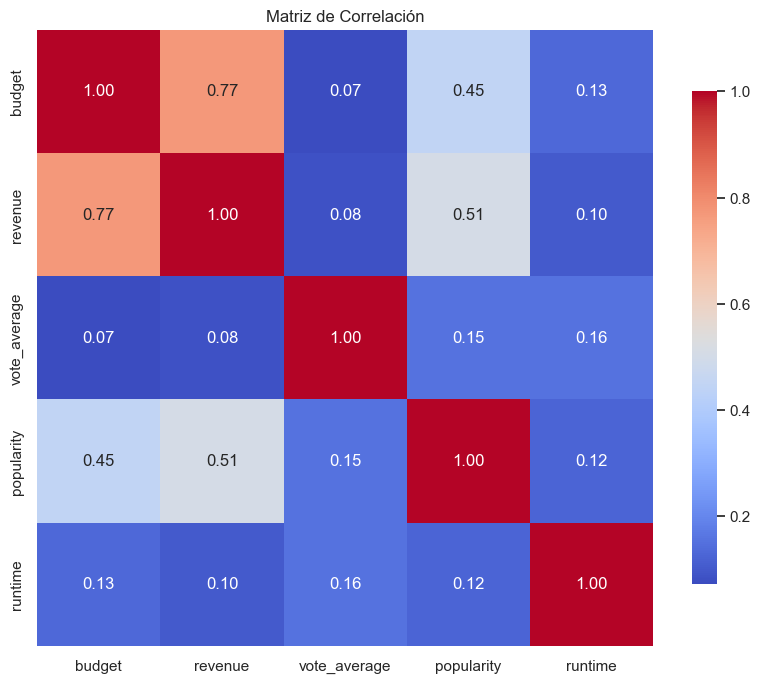

In [20]:
# Definir la ruta de tu dataset
ruta_movies = 'Datasets/movies_df.parquet'  # Reemplaza esto con la ruta correcta si es necesario

# Cargar el dataset
movies_df = pd.read_parquet(ruta_movies)  # Asegúrate de que el archivo esté en formato Parquet

# Seleccionar las variables para la matriz de correlación
variables = ['budget', 'revenue', 'vote_average', 'popularity', 'runtime']

# Calcular la matriz de correlación
correlation_matrix = movies_df[variables].corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})

# Títulos y etiquetas
plt.title('Matriz de Correlación')
plt.show()


En este gráfico de correlación, observo una relación significativa entre el **presupuesto** y los **ingresos** de las películas (0.77), lo cual indica que las películas con mayores presupuestos tienden a generar mayores ingresos. También noto que la **popularidad** tiene una correlación moderada tanto con los ingresos (0.51) como con el presupuesto (0.45), lo que sugiere que estas variables influyen en su éxito. Esta información me servirá para el modelo de recomendación, ya que al conocer las relaciones entre variables puedo identificar películas similares en función de estas características.

In [21]:
# Selección de columnas para la matriz de correlación
correlation_columns = ['budget', 'revenue', 'popularity', 'return']
correlation_matrix = df[correlation_columns].corr()


NameError: name 'df' is not defined

#### **Contar los miembros del Crew y Cast**

Contaré los miembros del crew y el cast por película, ya que esto podría influir en el éxito o la popularidad de una película y es relevante para descubrir posibles correlaciones.

In [ ]:
# Contar el número de miembros del crew y del cast
movies_with_full_info['crew_count'] = movies_with_full_info.groupby('id')['crew_name'].transform('nunique')
movies_with_full_info['cast_count'] = movies_with_full_info.groupby('id')['cast_name'].transform('nunique')

# Verificamos las nuevas columnas
print(movies_with_full_info[['id', 'crew_count', 'cast_count']].drop_duplicates().head())

         id  crew_count  cast_count
0       862          97          13
1378   8844          16          26
1794  15602           3           7
1822  31357           7          10
1922  11862           6          12


He calculado el número de miembros del crew y el cast para cada película. Por ejemplo, algunas películas tienen un equipo técnico muy grande, como la película con id 862, que tiene 97 personas en el crew y 13 en el cast, mientras que otras son más modestas, con solo unos pocos miembros en cada grupo. Esto me ayudará a analizar si la cantidad de personas involucradas tiene algún impacto en las métricas de éxito de las películas.

#### **Análisis Univariable de Popularity y Runtime**

Estoy explorando de forma univariable las distribuciones de popularity y runtime. Utilizo histogramas para visualizar la frecuencia de los valores de estas variables. Esto me permite observar si hay sesgos o posibles valores atípicos que puedan influir en el modelo de recomendación.

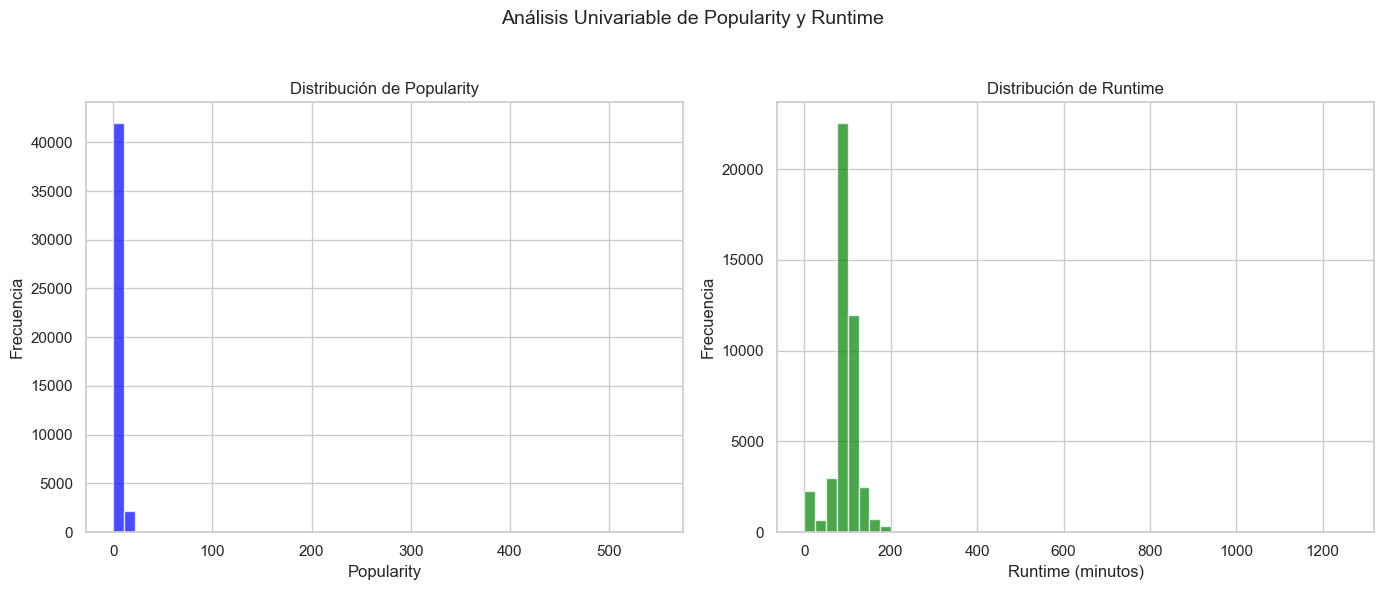

In [ ]:
# Crear una figura con dos gráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Análisis Univariable de Popularity y Runtime', fontsize=14)

# Histograma de la variable 'popularity'
axes[0].hist(movies_df['popularity'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribución de Popularity')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Frecuencia')

# Histograma de la variable 'runtime'
axes[1].hist(movies_df['runtime'].dropna(), bins=50, color='green', alpha=0.7)
axes[1].set_title('Distribución de Runtime')
axes[1].set_xlabel('Runtime (minutos)')
axes[1].set_ylabel('Frecuencia')

# Mostrar los gráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el diseño para que no se solapen con el título
plt.show()


Los histogramas muestran una distribución muy sesgada en ambas variables: popularity parece tener un gran sesgo hacia la izquierda, con la mayoría de los valores concentrados en un rango muy pequeño, mientras que runtime muestra un patrón más centralizado, pero con algunos valores extremos. Esto sugiere que podría ser útil realizar un tratamiento adicional de valores atípicos o una transformación para normalizar estas variables antes del modelado.

#### **Analizar los valores atípicos en las variables popularity y runtime**

Voy a analizar los valores atípicos en las variables popularity y runtime utilizando boxplots. Esto me ayudará a visualizar de manera clara los outliers presentes en cada distribución. Dependiendo de los resultados, puedo decidir aplicar transformaciones logarítmicas o técnicas de recorte para minimizar el impacto de estos valores extremos.

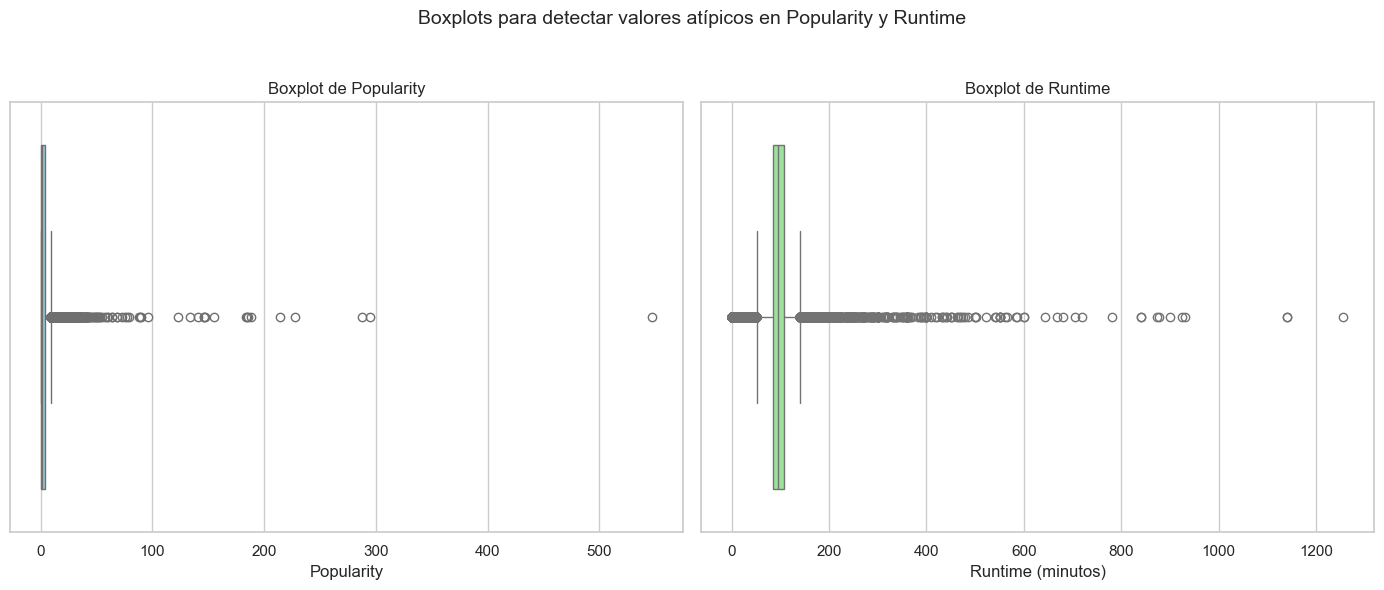

In [ ]:
# Configuración de los gráficos
plt.figure(figsize=(14, 6))
plt.suptitle('Boxplots para detectar valores atípicos en Popularity y Runtime', fontsize=14)

# Boxplot para Popularity
plt.subplot(1, 2, 1)
sns.boxplot(data=movies_df, x='popularity', color='skyblue')
plt.title('Boxplot de Popularity')
plt.xlabel('Popularity')

# Boxplot para Runtime
plt.subplot(1, 2, 2)
sns.boxplot(data=movies_df, x='runtime', color='lightgreen')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


En el gráfico de popularity, se observan películas extremadamente populares que se destacan como outliers, mientras que en runtime se pueden ver algunas películas inusualmente cortas o largas. Evaluaré si vale la pena transformar o recortar estos valores según su impacto en el modelo de recomendación.

#### **Eliminar outliers basados en el rango intercuartílico (IQR)**

In [ ]:
# Definir una función para eliminar outliers basados en el rango intercuartílico (IQR)
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    # Definir los límites inferior y superior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Filtrar el DataFrame para mantener solo los valores dentro de los límites
    return df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

# Aplicar la función a las columnas 'popularity' y 'runtime'
movies_df = eliminar_outliers(movies_df, 'popularity')
movies_df = eliminar_outliers(movies_df, 'runtime')

# Mostrar las primeras filas para confirmar
print(movies_df.head())


     budget     id original_language  \
3  16000000  31357                en   
4         0  11862                en   
6  58000000  11860                en   
7         0  45325                en   
8  35000000   9091                en   

                                            overview  popularity release_date  \
3  Cheated on, mistreated and stepped on, the wom...    3.859495   1995-12-22   
4  Just when George Banks has recovered from his ...    8.387519   1995-02-10   
6  An ugly duckling having undergone a remarkable...    6.677277   1995-12-15   
7  A mischievous young boy, Tom Sawyer, witnesses...    2.561161   1995-12-22   
8  International action superstar Jean Claude Van...    5.231580   1995-12-22   

      revenue  runtime    status                        title  vote_average  \
3  81452156.0    127.0  Released            Waiting to Exhale           6.1   
4  76578911.0    106.0  Released  Father of the Bride Part II           5.7   
6         0.0    127.0  Released   

Al aplicar la función para eliminar outliers basados en el rango intercuartílico, he notado que se han mantenido las películas con niveles de popularidad y duración más moderados. Esto debería ayudar a que el modelo de recomendación sea más efectivo al centrarse en datos más representativos, reduciendo el impacto de las películas extremas en el análisis.

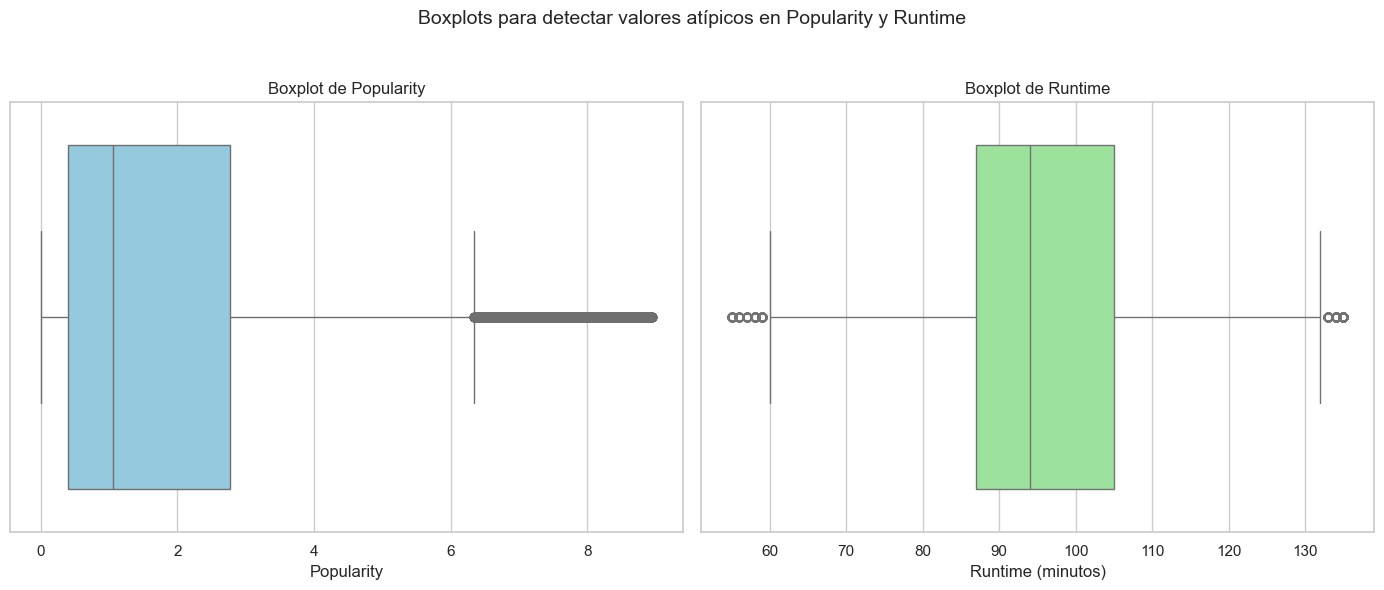

In [ ]:
# Configuración de los gráficos
plt.figure(figsize=(14, 6))
plt.suptitle('Boxplots para detectar valores atípicos en Popularity y Runtime', fontsize=14)

# Boxplot para Popularity
plt.subplot(1, 2, 1)
sns.boxplot(data=movies_df, x='popularity', color='skyblue')
plt.title('Boxplot de Popularity')
plt.xlabel('Popularity')

# Boxplot para Runtime
plt.subplot(1, 2, 2)
sns.boxplot(data=movies_df, x='runtime', color='lightgreen')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Después de eliminar los outliers, generé nuevamente los boxplots de 'Popularity' y 'Runtime'. En estos gráficos se puede observar una reducción en la presencia de valores extremos, especialmente en la variable de Popularity, donde los puntos fuera del rango principal han disminuido notablemente. Esto sugiere que el ajuste fue exitoso y que los datos ahora reflejan una distribución más representativa, lo cual facilitará el análisis y el modelado posterior.

#### **Visualización con una Nube de Palabras**

Usaré una nube de palabras para visualizar las palabras más comunes en los títulos de las películas. 

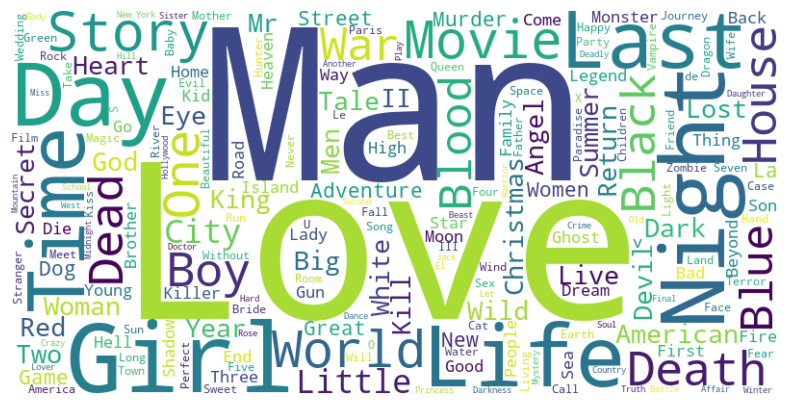

In [ ]:
# Concatenar todos los títulos en una sola cadena de texto
text = " ".join(movies_df['title'].values)

# Generar la nube de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Generé una nube de palabras basada en los títulos de las películas, lo que me permite visualizar las palabras más frecuentes en estos títulos. En esta representación gráfica, las palabras como "Man", "Love", "Life", "Last", y "Girl" aparecen en un tamaño mayor, indicando que son comunes en los títulos de las películas. Esto sugiere que los temas de amor, vida, y personajes como el hombre o la mujer son recurrentes, algo que podría ser relevante al construir un sistema de recomendación que considere la popularidad de ciertos temas.

Este análisis inicial proporciona una idea de los conceptos principales y temas frecuentes en los títulos, lo cual es útil para explorar patrones o tendencias en los datos. Esta información podría ayudar a refinar las recomendaciones, ya que temas populares podrían guiar los gustos de los usuarios en el sistema de recomendación.

#### **Análisis de palabras más frecuentes en títulos de películas**

 Quiero explorar el contenido textual de los títulos de las películas. Para esto, usaré una nube de palabras que me permitirá visualizar los términos más comunes en los títulos y obtener una idea de los temas o géneros populares. Esta información podría mejorar el sistema de recomendación al resaltar palabras clave útiles para categorizar y sugerir películas similares.